In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import average_precision_score
# from sklearn.metrics import ndcg_score

In [3]:
class OUNoise:

    def __init__(self, a_dim, mu=0, theta=0.5, sigma=0.2):
        self.a_dim = a_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.a_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.a_dim) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.rand(len(x))
        self.state = x + dx
        return self.state

In [4]:
noise = OUNoise(30)
dd_array = noise.noise()
dd_array = dd_array.reshape(5,6)

In [5]:
np.identity(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Epsilon greedy with decay

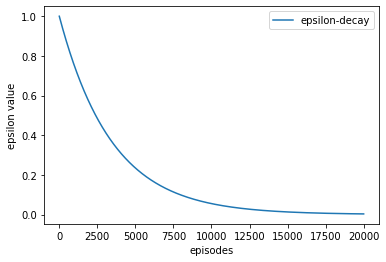

In [46]:
def plot_epsilon_hyper_param(epochs):
    x_axis = np.arange(0, epochs)
    epsilon = []
    epsilon1 = []
    for i in range(0, epochs):
        epsilon.append(np.exp(-0.00029 * i))
#         epsilon1.append(np.exp(-0.000045 * i))

    plt.plot(x_axis, epsilon, label="epsilon-decay")
#     plt.plot(x_axis, epsilon1, label="2")
    plt.xlabel('episodes')
    plt.ylabel('epsilon value')
    plt.legend()
    plt.show()
    
plot_epsilon_hyper_param(20000)

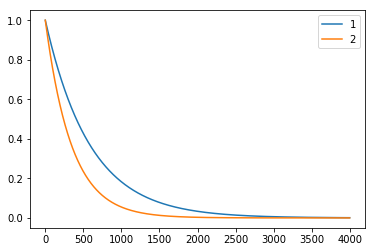

In [13]:
def plot_epsilon_hyper_param(epochs):
    x_axis = np.arange(0, epochs)
    epsilon = []
    epsilon1 = []
    for i in range(0, epochs):
        epsilon.append(np.exp(-0.0017 * i))
        epsilon1.append(np.exp(-0.0029 * i))

    plt.plot(x_axis, epsilon, label="1")
    plt.plot(x_axis, epsilon1, label="2")
    plt.legend()
    plt.show()
    
plot_epsilon_hyper_param(4000)

In [134]:
2.9e-6

2.9e-06

In [16]:
def average_precision_k(actual_list, pred_list, top_k, threshold_val):
    relev_list = actual_list
    if len(actual_list) > top_k:
        relev_list = actual_list[:top_k]

    if len(relev_list) == 0:
        return 0.0

    score = 0.0
    num_hits = 0.0
    for i, actual_rate in enumerate(relev_list):
        if pred_list[i] >= threshold_val:
            num_hits = num_hits + 1.0
            score = score + (num_hits / (i + 1.0))

    avg_prec = score / min(len(relev_list), top_k)
    return avg_prec

In [17]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, a, k, method=0):
    dcg_max = dcg_at_k(a, k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [74]:
BASE_PATH = 'C:/Users/sjana/Learning/LJMU-masters/recommender_system/backup/'
SUB_FOLDER_PATH = 'iteration_19_15Users_4k_DQN_SARSA/'

In [75]:
epi_data = BASE_PATH+SUB_FOLDER_PATH+'dqn_episode_total_rewards.pkl'
user_data = BASE_PATH+SUB_FOLDER_PATH+'dqn_user_state_rewards.pkl'
qdn_train_data = BASE_PATH+SUB_FOLDER_PATH+'dqn_train_loss.pkl'
qvalue_tracking = BASE_PATH+SUB_FOLDER_PATH+'dqn_qvalue_tracking.pkl'

## Total rewards per episode

In [76]:
with (open(epi_data, "rb")) as openfile:
    data = pickle.load(openfile)

print_dict = dict()
calc_dict = dict()
for key,valye in data.items():
#     print('key {} and valye {}'.format(key, valye))
    print_dict[key] = np.sum(valye)
    calc_dict[key] = np.mean([np.sum(val) for val in valye])
    
len(print_dict)

4001

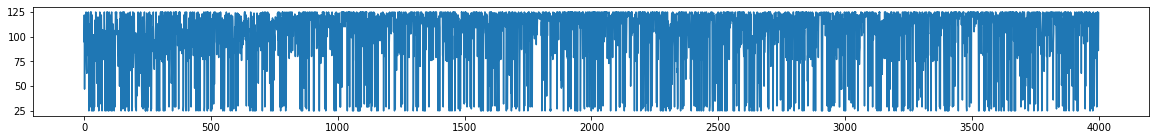

In [77]:
lists = print_dict.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
# x = x[35000:36000]
# y = y[35000:36000]
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.plot(x, y)
# ax.set_yscale('log')
plt.show()

## user precision

In [78]:
# analysis = 'D:/Learning/LJMU-masters/recommender_system/project-code/acc_test_user_state_rewards.pkl'
with (open(user_data, "rb")) as openfile: # user_data
    user_dd = pickle.load(openfile)
    
print(len(user_dd.keys()))

15


In [79]:
prec_map = list()
ndcg_map = list()
for each_user in list(user_dd.keys()):
    data_df = pd.DataFrame(user_dd[each_user])
    data_df['ndcg'] = data_df.reward_vect.apply(lambda rew: ndcg_at_k(rew, [5]*len(rew), len(rew)))
    data_df['avg_prec'] = data_df.prec_vect.apply(lambda pred: average_precision_k([1]*len(pred), pred, len(pred), 1.0))
#     display(data_df.tail(15))
#     print(data_df.iloc[570]['action'])
    prec_map.append(data_df.avg_prec.mean())
    ndcg_map.append(data_df.ndcg.mean())
#     print(data_df.avg_prec.mean())
#     print(data_df.ndcg.mean())
    
print(np.mean(prec_map))
print(np.mean(ndcg_map))


0.7830463543097943
0.7999567376280489


In [80]:
print(list(user_dd.keys()))
# user_dd["['d6qorI6Ez37znpgGLPOEOg']"]

['_ZfspWZBVzlXlSEESofrMQ', 'bKzLbgvl_83eSxZxKrUspw', 'tBpyi-tXOYQlkjtQKPd5aw', 'mz-tqIBJd7Q8y-eCpN-wfQ', 'x8e1Cc1lh835Q1CpHAD0RQ', 'I1Jhth-yxtz4mty6C2sWqg', 'IBO0RWBMGbGziHUVq-j0IQ', '3H5Ty7TV7SZvZLa1oTUGDg', 'f_z_JtNybp_0d0eWO75JUQ', 'RdgVjfiiIXnNgA3CwEFvDg', '_n1lAWEDLmxx43K87B-KPA', 'ZWTR80zMUGlfcYMjTSQm0A', 'i7mBC7m7k2FLrdVUx0UqUg', 'FKH6bgsPuaoH_cQJopBEBg', 'evxG8WxjD7r0Z7XIjXWHmQ']


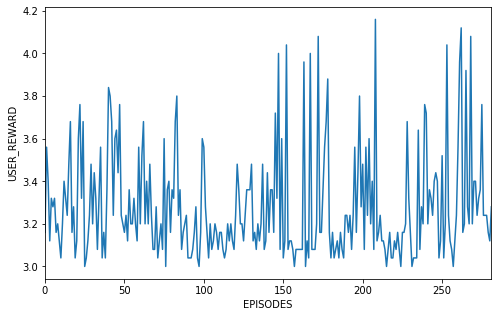

In [90]:
# djpMXOA1ic5wv3FPtubHNw, IWZweDQUlsKfLS1_olQqlA, KOHvhD69T7rlnK7zKO2wmA
# rwxysHWeugwQ1sJFI4AQdw, 3jwldoOr926Ys2mLNMp_eg, rDwEgqNlzclq5odMmWBQFg
user_id = "IBO0RWBMGbGziHUVq-j0IQ"
dd = pd.DataFrame(user_dd[user_id])
dd['reward_sum'] = dd.reward_vect.apply(lambda x:np.mean(x))
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.xlabel('EPISODES')
plt.ylabel('USER_REWARD')
dd['reward_sum'].plot.line(label=user_id)

In [73]:
prec_map

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.8608773455377573,
 0.6633445714573188,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7973900124463864,
 0.7704557836025866,
 1.0,
 1.0,
 0.0,
 0.6430679147806622,
 0.05087301587301587,
 1.0,
 1.0,
 1.0,
 0.6853929486406267,
 0.0,
 0.038793776272037145,
 1.0,
 0.04,
 1.0,
 1.0,
 0.21050102216325123,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.004866666666666667,
 1.0,
 1.0,
 0.39644773956693463,
 0.04,
 1.0,
 1.0,
 0.7988881365445104,
 0.7346046914453161,
 0.02,
 1.0,
 1.0,
 0.7333966092387146,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.7776184769553595,
 0.04,
 0.9584,
 0.07627142857142857,
 0.0,
 1.0,
 0.8673616728898597,
 1.0,
 1.0,
 0.6279863740991215,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9567333333333333,
 0.6584129194491963,
 0.0,
 1.0,
 0.04615384615384615,
 0.7736010844661537,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8806950062231929,
 0.0,
 1.0,
 1.0,
 0.96,
 1.0,
 0.621446691559439,
 1.0,
 1.0,
 1.0,
 0.04,

In [16]:
# final_df.iloc[2000]['action']

## DQN Agent loss tracking

In [28]:
# TODO: find the average loss per episode for tracking
with (open(qdn_train_data, "rb")) as openfile:
    dqn_loss_dd = pickle.load(openfile)
    
len(dqn_loss_dd)

20001

In [120]:
# dqn_loss_dd[400]

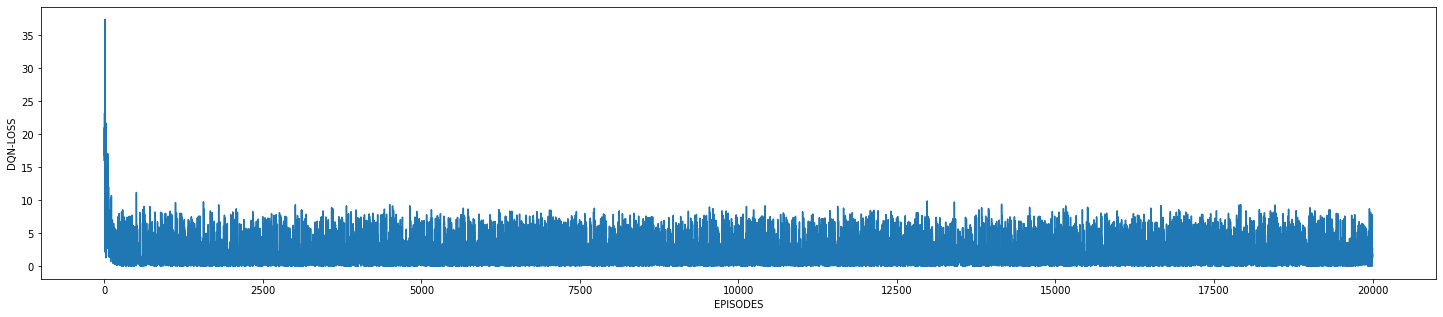

In [29]:
dqn_loss_dict = dict()
for key,valye in dqn_loss_dd.items():
    dqn_loss_dict[key] = np.mean(valye)

# dqn_loss_dd[1748][:-1]
lists = sorted(dqn_loss_dict.items()) # sorted by key, return a list of tuples
x_dqn, y_dqn = zip(*lists) # unpack a list of pairs into two tuples
# x_dqn = x_dqn[30000:]
# y_dqn = y_dqn[30000:]
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x_dqn, y_dqn)
# ax.set_yscale('log')
plt.xlabel('EPISODES')
plt.ylabel('DQN-LOSS')
plt.show()

## Q Value tracking with episodes

In [30]:
# TODO: use np.linalgo.norm for calculating the vector magnitude.
with (open(qvalue_tracking, "rb")) as openfile:
    qvalue_dd = pickle.load(openfile)

qvalues_dict = dict()
for key,valye in qvalue_dd.items():
    valye = np.asarray(valye)
    qvalues_dict[key] = np.mean(valye)

len(qvalues_dict)

20001

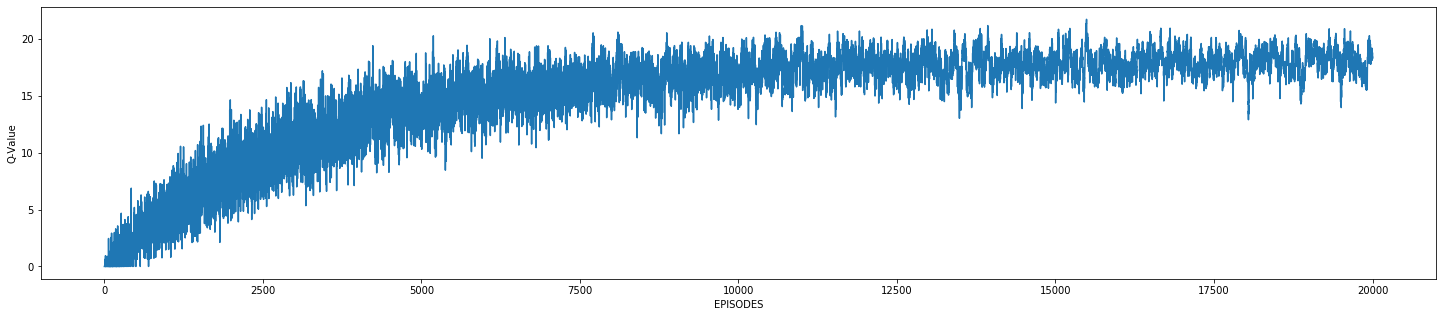

In [31]:
lists = sorted(qvalues_dict.items()) # sorted by key, return a list of tuples
x_qval, y_qval = zip(*lists) # unpack a list of pairs into two tuples
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x_qval, y_qval)
# ax.set_yscale('log')
plt.xlabel('EPISODES')
plt.ylabel('Q-Value')
plt.show()